# Research of advertisements for housing sale

You have been granted access to a data archive from Yandex.Real Estate service, containing advertisements for apartments on sale in St. Petersburg and nearby towns over the past several years. The objective is to develop a method to determine the market value of these real estate properties. Your task is to establish the necessary parameters to create an automated system that can detect anomalies and fraudulent activities.

For each apartment on sale, two types of data are available. The first type is user-entered data, while the second type is generated automatically using cartographic data, such as the distance to the city center, airport, nearest park, and water body.

## Data review

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import warnings

In [2]:
try:
    df = pd.read_csv("/datasets/real_estate_data.csv", sep="\t")
except FileNotFoundError:
    try:
        df = pd.read_csv("real_estate_data.csv", sep="\t")
    except FileNotFoundError:
        try:
            df = pd.read_csv(r"real_estate_data.csv", sep="\t")
        except FileNotFoundError:
            print("File not found")
    
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [3]:
print("Shape of dataframe:", df.shape)
print("-" * 26)
print("Missing values:", "\n")
print(df.isna().mean().sort_values())
print("-" * 26)
print("Duplicates:", "\n")
print(df.duplicated().sum())
print("-" * 26)
print("Data type:", "\n")
print(df.dtypes)
display(df.describe())
df.head()

Shape of dataframe: (23699, 22)
--------------------------
Missing values: 

total_images            0.000000
open_plan               0.000000
floor                   0.000000
rooms                   0.000000
studio                  0.000000
total_area              0.000000
last_price              0.000000
first_day_exposition    0.000000
locality_name           0.002068
floors_total            0.003629
living_area             0.080299
kitchen_area            0.096122
days_exposition         0.134225
ponds_around3000        0.232837
parks_around3000        0.232837
cityCenters_nearest     0.232879
airports_nearest        0.233850
ceiling_height          0.387991
balcony                 0.486054
ponds_nearest           0.615596
parks_nearest           0.659100
is_apartment            0.882906
dtype: float64
--------------------------
Duplicates: 

0
--------------------------
Data type: 

total_images              int64
last_price              float64
total_area              float64
fir

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Conclusion

Here's what was found while first glance of data:
- Missing values
- DF contains duplicates
- Check and fix dtype of data.

## Data preprocessing

### Missing values

In [4]:
df.isna().mean().sort_values() * 100

total_images             0.000000
open_plan                0.000000
floor                    0.000000
rooms                    0.000000
studio                   0.000000
total_area               0.000000
last_price               0.000000
first_day_exposition     0.000000
locality_name            0.206760
floors_total             0.362885
living_area              8.029875
kitchen_area             9.612220
days_exposition         13.422507
ponds_around3000        23.283683
parks_around3000        23.283683
cityCenters_nearest     23.287902
airports_nearest        23.384953
ceiling_height          38.799105
balcony                 48.605426
ponds_nearest           61.559559
parks_nearest           65.909954
is_apartment            88.290645
dtype: float64

The possible reasons of missing values could be:
- Advertisements do not include all information for each column, or it is not available due to some reasons (no balcony, ceiling height not specified)
- It is possible that errors could take place while creating the advertisements.

#### Living and kitchen area

Let's look for ratio between living and total area of flat, for further data gaps handling in `living_area` and `kitchen_area`:

In [5]:
total_living_ratio = df["total_area"].mean() / df["living_area"].mean()
total_kitchen_ratio = df["total_area"].mean() / df["kitchen_area"].mean()
print("Total Living Ratio:", total_living_ratio)
print("Total Kitchen Ratio:", total_kitchen_ratio)

Total Living Ratio: 1.751375861996321
Total Kitchen Ratio: 5.709531864143031


Filling the missing value for `living_area` and `kitchen_area` with values above:

In [6]:
df["living_area"].fillna((df["total_area"] / total_living_ratio), inplace=True)
df["kitchen_area"].fillna((df["total_area"] / total_kitchen_ratio), inplace=True)
display(df["living_area"].isna().sum())
df["kitchen_area"].isna().sum()

0

0

#### Locality name

Missing values will be replaced with `unknown` to keep as much data as possible.

In [7]:
df["locality_name"].fillna("unknown", inplace=True)
df["locality_name"].isna().sum()

0

#### Amount of floors

In [8]:
df["floors_total"].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52., 37.])

In [9]:
np.where(pd.isnull(df["floors_total"]))

(array([  186,   237,   457,   671,  1757,  1930,  2392,  2846,  2952,
         3031,  3438,  3817,  3831,  4140,  4617,  4848,  4901,  5146,
         5187,  5784,  5958,  6030,  6136,  6288,  7508,  7662,  7922,
         8478,  8986,  9023,  9415,  9979, 10004, 10013, 10027, 10058,
        10259, 10319, 10351, 10486, 10531, 10568, 10662, 10880, 10983,
        11129, 11292, 11328, 11389, 11425, 12104, 12352, 12399, 12739,
        13438, 13622, 13955, 14094, 14153, 14264, 14526, 14717, 15989,
        16496, 16549, 16591, 16668, 16850, 17498, 17721, 17925, 18832,
        19133, 19350, 19452, 20146, 20250, 20738, 21273, 21651, 21753,
        22542, 22656, 22808, 23590, 23658]),)

For data purification, all entries (0.3%) with no values in `floors_total` will be dropped

In [10]:
df = df.dropna(subset=["floors_total"])

#### Ceiling height

In [11]:
df["ceiling_height"].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Missing values will be replaced with median:

In [12]:
df["ceiling_height"].fillna(df["ceiling_height"].median(), inplace=True)
df["ceiling_height"].isna().sum()

0

#### Number of balconies

In [13]:
df["balcony"].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Empty data in `balcony` replaced with "0". It is very unlikely that lack of balcony was not specified to intend.

In [14]:
df["balcony"].fillna(0, inplace=True)
df["balcony"].isna().sum()

0

#### Apartments vs flats

In [15]:
df["is_apartment"].unique()

array([nan, False, True], dtype=object)

The replacement of missing values to the "False" boolean type was made. The reason for this is following: if there is no statement regarding apartments in ads, then these are residential premises (flats). Apartments refer to non-residential premises.

In [16]:
df["is_apartment"] = df["is_apartment"].fillna(False)
df["is_apartment"].unique()

array([False,  True])

#### Housing layout

In [17]:
df["studio"].unique()

array([False,  True])

As expected, the housing could be a studio or not, and the same applies to `open plan`:

In [18]:
df["open_plan"].unique()

array([False,  True])

#### Advertisement display period

In [19]:
df["days_exposition"].isna().sum()
df["days_exposition"] = df["days_exposition"].fillna(0)

Removed NaN values in days to convert them to an integer type in step 2.3

In [20]:
df.isna().mean().sort_values() * 100

total_images             0.000000
locality_name            0.000000
balcony                  0.000000
kitchen_area             0.000000
open_plan                0.000000
is_apartment             0.000000
floor                    0.000000
studio                   0.000000
floors_total             0.000000
ceiling_height           0.000000
rooms                    0.000000
first_day_exposition     0.000000
total_area               0.000000
last_price               0.000000
living_area              0.000000
days_exposition          0.000000
parks_around3000        23.326134
ponds_around3000        23.326134
cityCenters_nearest     23.330369
airports_nearest        23.427773
ponds_nearest           61.627070
parks_nearest           65.929784
dtype: float64

### Checking data for duplicates

In [21]:
df.duplicated().sum()

0

There are no obvious duplicates in the dataframe. I will investigate the names of the populated areas for potential duplicates.

#### Names of settlements

In [22]:
len(df["locality_name"].unique())

365

There are many different types of populated areas, such as village, urban-type settlement, urban settlement, and so on. Plus, there are Cyrillic letter "ё" which cause difficulties.

In [23]:
df["locality_name"] = df["locality_name"].str.replace("ё", "е")
len(df["locality_name"].unique())

331

### Replacing the data type

In [24]:
df["first_day_exposition"] = pd.to_datetime(df["first_day_exposition"], format="%Y-%m-%d")
df["first_day_exposition"].unique()

array(['2019-03-07T00:00:00.000000000', '2018-12-04T00:00:00.000000000',
       '2015-08-20T00:00:00.000000000', ...,
       '2014-12-29T00:00:00.000000000', '2016-09-12T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [25]:
df["floors_total"] = df["floors_total"].astype("int")
df["balcony"] = df["balcony"].astype("int")
df["days_exposition"] = df["days_exposition"].astype("int")

In [26]:
df.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                  int64
dtype: object

The "first_day_exposition" column had hours, minutes, and seconds excluded since there were only zeroes in the original data. The "floors_total", "balcony", and "days_exposition" columns were converted to integer values to simplify display and eliminate unnecessary data.

### Conclusion

1. During the data preprocessing, the following missing values were identified and processed:
  - In the living area and kitchen area, based on the ratio of total area to living/kitchen area;
  - In the names of settlements - replaced with "unknown" for clarity (46 ads);
  - Number of floors - removed from the dataset (86 ads);
  - Number of balconies - missing values were replaced with zeros because the absence of balconies in the ad clearly indicates that the property has no balconies;
  - Type of property (apartment or not). Where it was not specified that the property is an apartment, missing values were replaced with the value False.
2. Duplicate processing:
  - When analyzing the names of settlements, duplicate values were found due to the letters "e" and "ё" in the names. All "ё" letters were replaced with "е";
  - No other duplicates were found in the dataset.
3. Data replacement:
  - In the date format, data on hours, minutes, and seconds were removed - useless information;
  - Data in the columns "floors_total", "balcony", and "days_exposition" were converted to integers, fractional parts do not contain any information.

## Calculations and adding results to the table

### Price per square meter

The data will be added to the "price_per_square" column

In [27]:
df["price_per_square"] = df["last_price"] / df["total_area"]
df["price_per_square"] = df["price_per_square"].round(0)

### Day of the week, month and year of publication of the announcement

The data will be added to the columns "exposition_day", "exposition_month" and "exposition_year"

In [28]:
df["exposition_day"] = df["first_day_exposition"].dt.day_name()
df["exposition_month"] = df["first_day_exposition"].dt.month_name()
df["exposition_year"] = df["first_day_exposition"].dt.year

### Apartment floor

Options - first, last, another. I'll add categories via a function to the `floor_name` column:

In [29]:
def floor_name(row):
    if row["floor"] == 1:
        return "первый этаж"
    elif row["floor"] == row["floors_total"]:
        return "последний этаж"
    else:
        return "другой этаж"

In [30]:
df["floor_name"] = df.apply(floor_name, axis=1)

### The ratio of living and total area

Also the ratio of the area of ​​the kitchen to the total. Data added to "total_living_area_ratio" and "total_kitchen_area_ratio" columns:

In [31]:
df["total_living_area_ratio"] = df["living_area"] / df["total_area"]
df["total_kitchen_area_ratio"] = df["kitchen_area"] / df["total_area"]

What the dataframe looks like with the new columns:

In [32]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square,exposition_day,exposition_month,exposition_year,floor_name,total_living_area_ratio,total_kitchen_area_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,0,120370.0,Thursday,March,2019,другой этаж,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.000000,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82921.0,Tuesday,December,2018,первый этаж,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92786.0,Thursday,August,2015,другой этаж,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.785766,9,False,False,False,27.848168,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.0,Friday,July,2015,другой этаж,0.570980,0.175146
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.0,Tuesday,June,2018,другой этаж,0.320000,0.410000


## EDA (Exploratory data analysis)

### The research of individual parameters and the construction of histograms

#### Apartment area

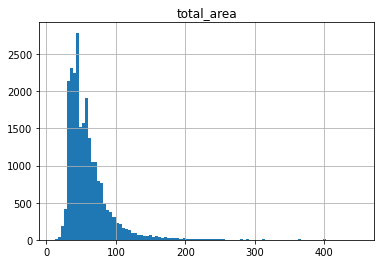

In [33]:
df.hist("total_area", bins=100, range=(12, 450))
plt.show()

The minimum and maximum values in the "total_area" column are 12 and 900, respectively. For the sake of clarity of the histogram, I halved the maximum value. It can be seen that the majority of apartments have an area of around 50 square meters.

#### The price

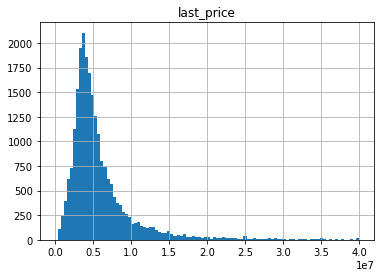

In [34]:
df.hist("last_price", bins=100, range=(0,40000000))
plt.show()

Not very informative, let's look at the box plot:

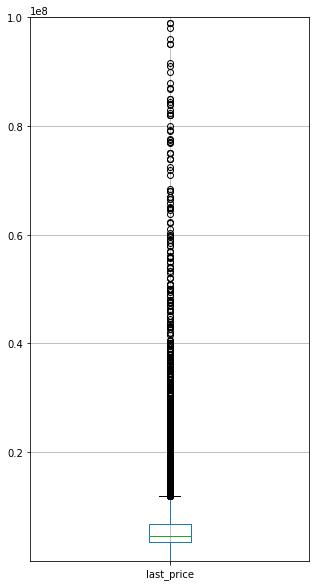

In [35]:
df.boxplot("last_price", figsize=(5, 10))
plt.ylim(1,100000000)
plt.show()

The average price of an apartment in the region is around 6.5 million rubles.

#### Number of rooms

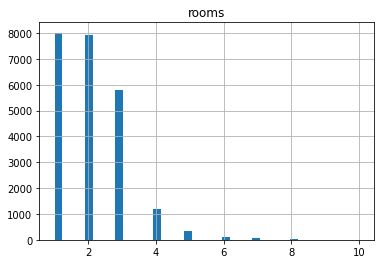

In [36]:
df.hist("rooms", bins=40, range=(1, 10))
plt.show()

The overwhelming majority of the ads are for one-room apartments, followed by two-room apartments.

#### Ceiling height

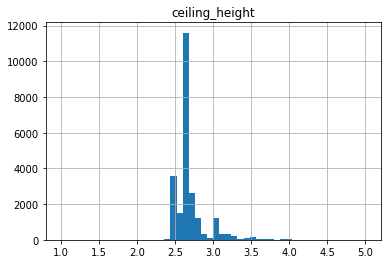

In [37]:
df.hist("ceiling_height", bins=50, range=(1, 5))
plt.show()

The average ceiling height is 2.5–3 meters.

### Apartment sale time

In [38]:
df[df["days_exposition"]!=0]["days_exposition"].describe()

count    20441.000000
mean       180.884839
std        219.685543
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

The average time for selling a property is 95 days, while the median is 180. The difference is almost twice as large. Let me visualize it:

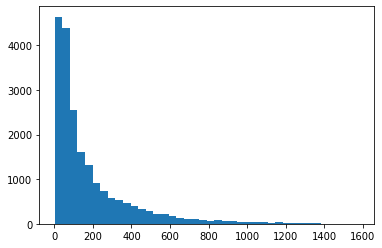

In [39]:
plt.hist(df[df["days_exposition"]!=0]["days_exposition"], bins=40)
plt.show()

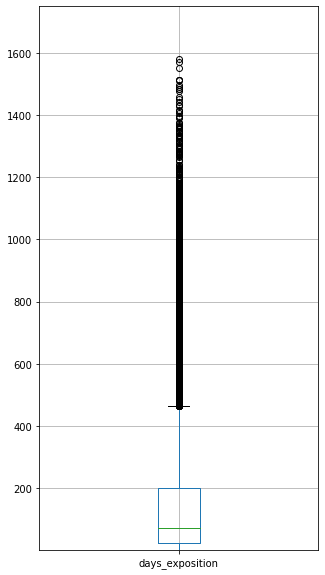

In [40]:
df.boxplot("days_exposition", figsize=(5, 10))
plt.ylim(1,1750)
plt.show()

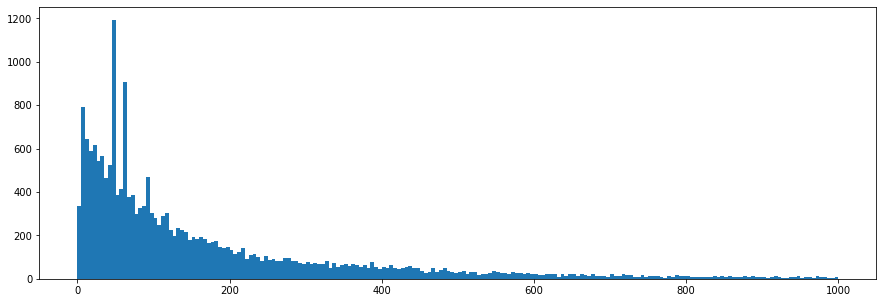

45      880
60      538
7       234
30      208
90      201
       ... 
1116      1
1325      1
1345      1
1232      1
971       1
Name: days_exposition, Length: 1139, dtype: int64

In [41]:
plt.figure(figsize=(15,5))

plt.hist(
    df[df["days_exposition"]!=0]["days_exposition"],
    bins=200,
    range=(0, 1000))
plt.show()
df[df["days_exposition"]!=0]["days_exposition"].value_counts()

Received many zeros because <a href="#days_exposition">missing values were replaced with zeros (2.1.8)</a>, so I looked at values without them. Outliers appeared around 45, 60, 7, 30, and 90 days. The number of days looks like some kind of rule, such as paid placement or something else. I will filter them into a new dataframe without outliers.

In [42]:
df_clean = df.query(
    """
    days_exposition != 45 and \
    days_exposition != 60 and \
    days_exposition != 7 and \
    days_exposition != 30 and \
    days_exposition != 90 and \
    days_exposition != 0
    """
)

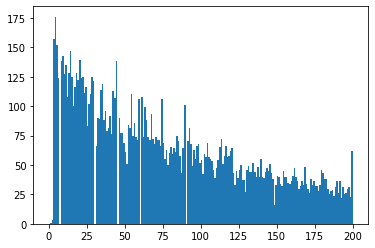

count    18380.000000
mean       195.844342
std        226.727016
min          1.000000
25%         44.000000
50%        114.000000
75%        259.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [43]:
plt.hist(
    df_clean[df_clean["days_exposition"]!=0]["days_exposition"],
    bins=200,
    range=(0, 200))
plt.show()
df_clean["days_exposition"].describe()

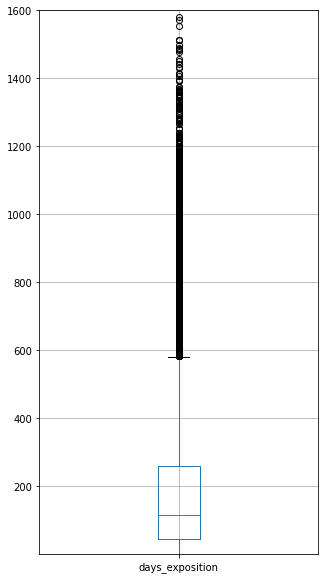

In [44]:
df_clean.boxplot("days_exposition", figsize=(5, 10))
plt.ylim(1,1600)
plt.show()

The average number of days it takes to sell an apartment is 114 days, and the median value is 195 days. We can assume that apartments are usually sold within a range of 50 to 600 days. Quick sales can be considered those apartments that were sold within a period of up to 100 days, while unusually long sales last more than 600 days.

### Cleaning up outliers

The outliers in the sales time have already been removed, I will check the others (area, price, number of rooms, ceiling height).


#### Area

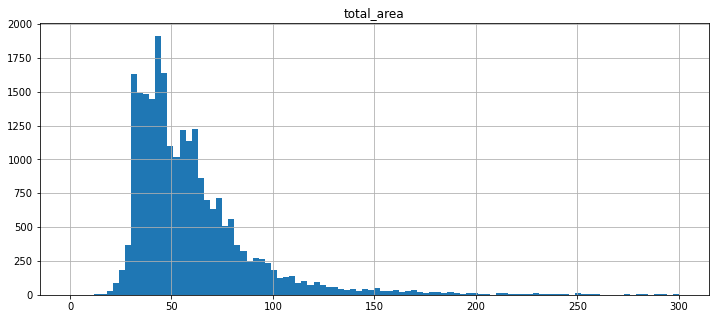

In [45]:
df.hist("total_area", bins=100, range=(0,300), figsize=(12,5))
plt.show()

There are outliers from 35 to 50 and a noticeable drop after 200 square meters, I will check the box plot.

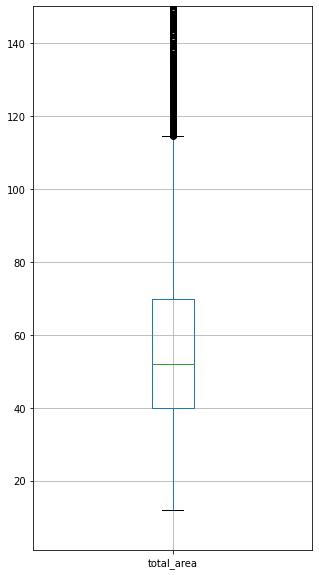

In [46]:
df.boxplot("total_area", figsize=(5, 10))
plt.ylim(1,150)
plt.show()

#### Price

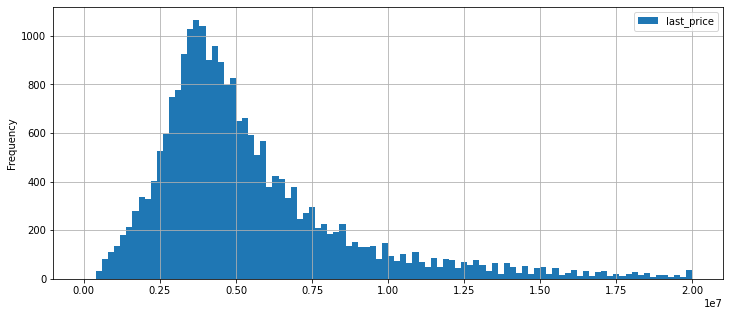

In [47]:
df.plot(
    y = "last_price",
    kind = "hist",
    bins = 100,
    grid=True,
    range = (0,20000000),
    figsize=(12,5))
plt.show()

Prices below 500,000 and above 20,000,000 are considered unreliable and will be removed.

#### Number of rooms

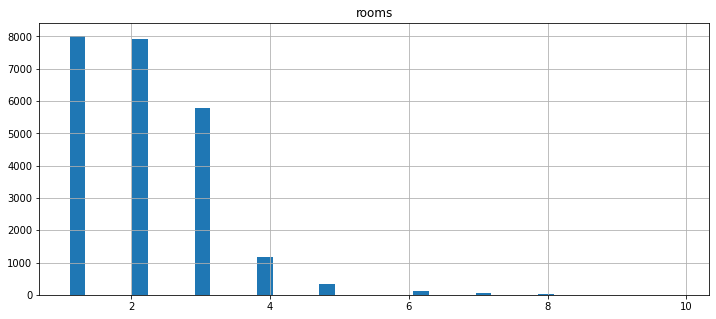

In [48]:
df.hist("rooms", bins=20, range=(1,10), rwidth=0.5, figsize=(12,5))
plt.show()

I will remove ads with "0" rooms as they appear to be errors.

#### Ceiling height

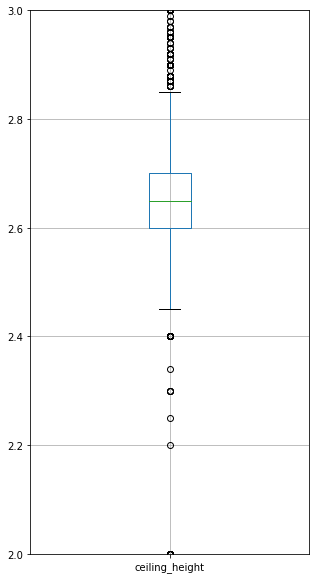

In [49]:
df.boxplot(column=["ceiling_height"], figsize=(5, 10))
plt.ylim(2, 3)
plt.show()

A noticeable predominance can be seen in the range from 2.5 to 3 meters, which is expected. But there are also strange data points at 100 meters. I suspect there are two-story apartments with a ceiling height of up to 10 meters.

#### Cleaning and graphs

I will remove the identified outliers and create graphs to visualize the changes:

In [50]:
df_clean = df.query(
    """
        (total_area > 10) & (total_area < 180) & \
        (last_price < 20000000) & (last_price > 500000) & \
        (rooms > 0) & (rooms < 7) & \
        (ceiling_height < 10) & (ceiling_height > 1.8)
    """
)

In [51]:
df_outliers = df.query("last_price > 20000000")

Ads with prices above 20 million have been removed to a separate dataframe, df_outliers. 703 ads do not affect the overall results but may still be useful.

Let's create 2x2 subplot with each histo plotted in a separate subplot:

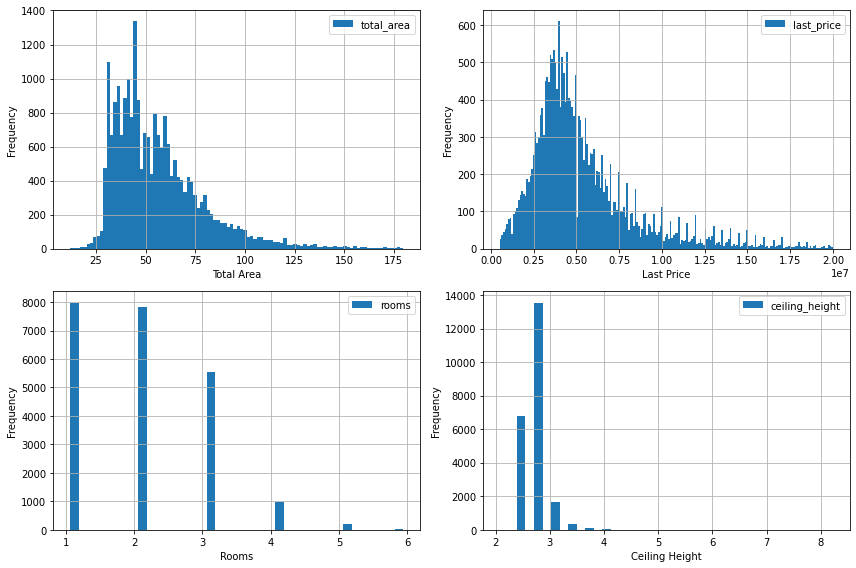

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

df_clean.plot(y="total_area", kind="hist", bins=100,
              grid=True, ax=axes[0, 0])
axes[0, 0].set_xlabel("Total Area")
axes[0, 0].set_ylabel("Frequency")

df_clean.plot(y="last_price", kind="hist", bins=200,
              grid=True, ax=axes[0, 1])
axes[0, 1].set_xlabel("Last Price")
axes[0, 1].set_ylabel("Frequency")

df_clean.plot(y="rooms", kind="hist", bins=20,
              grid=True, rwidth=0.5, ax=axes[1, 0])
axes[1, 0].set_xlabel("Rooms")
axes[1, 0].set_ylabel("Frequency")

df_clean.plot(y="ceiling_height", kind="hist", bins=20,
              grid=True, rwidth=0.5, ax=axes[1, 1])
axes[1, 1].set_xlabel("Ceiling Height")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

#### Conclusion

- Total area: ads with an area exceeding 180 square meters have been removed.
- Price: prices below 500,000 and above 20,000,000 rubles are considered unrepresentative and removed. Most of the ads fall within the range of 2.5 million to 7 million rubles.
- Number of rooms: ads with 0 rooms and more than 7 rooms have been removed since they are unrepresentative. The most popular type of apartment is a 2-room apartment.
- Ceiling height: the average ceiling height in the ads is 2.5-2.7 meters, which is consistent with information from open sources.

### Factors affecting apartment prices

The dependence of the price on the area, floor, number of rooms, and distance from the center.

In [53]:
df_clean["last_price_short"] = df_clean["last_price"] / 1000000

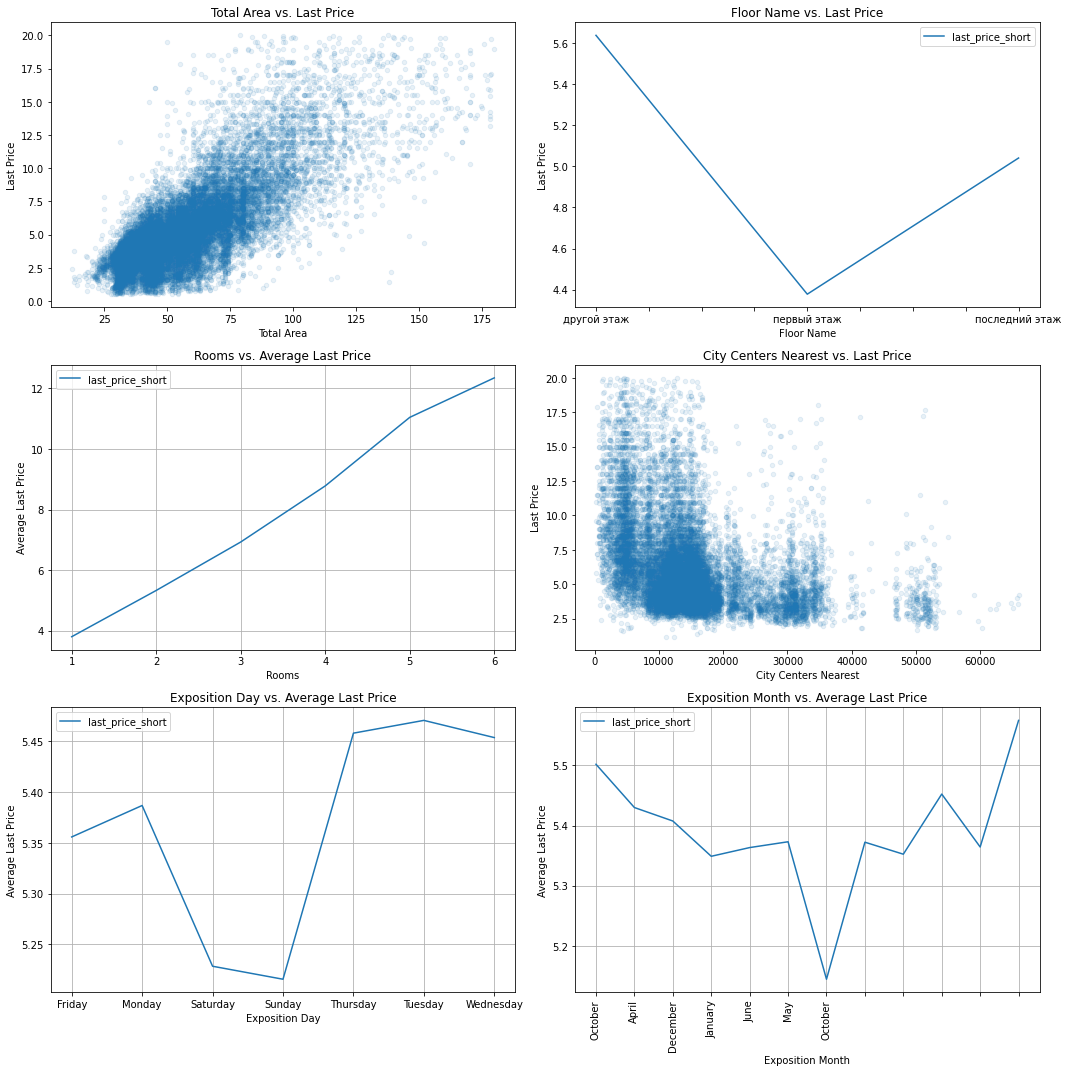

In [54]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

df_clean.plot(
    kind="scatter", x="total_area", y="last_price_short", alpha=0.1, ax=axs[0, 0]
)
axs[0, 0].set_title("Total Area vs. Last Price")
axs[0, 0].set_xlabel("Total Area")
axs[0, 0].set_ylabel("Last Price")

df_clean.pivot_table(index="floor_name", values="last_price_short").plot(ax=axs[0, 1])
axs[0, 1].set_title("Floor Name vs. Last Price")
axs[0, 1].set_xlabel("Floor Name")
axs[0, 1].set_ylabel("Last Price")

df_clean.pivot_table(index="rooms", values="last_price_short", aggfunc="mean").plot(
    ax=axs[1, 0], grid=True
)
axs[1, 0].set_title("Rooms vs. Average Last Price")
axs[1, 0].set_xlabel("Rooms")
axs[1, 0].set_ylabel("Average Last Price")

df_clean.plot(
    kind="scatter",
    x="cityCenters_nearest",
    y="last_price_short",
    alpha=0.1,
    ax=axs[1, 1],
)
axs[1, 1].set_title("City Centers Nearest vs. Last Price")
axs[1, 1].set_xlabel("City Centers Nearest")
axs[1, 1].set_ylabel("Last Price")

df_clean.pivot_table(index="exposition_day", values="last_price_short").plot(
    ax=axs[2, 0], grid=True
)
axs[2, 0].set_title("Exposition Day vs. Average Last Price")
axs[2, 0].set_xlabel("Exposition Day")
axs[2, 0].set_ylabel("Average Last Price")

df_clean.pivot_table(index="exposition_month", values="last_price_short").plot(
    ax=axs[2, 1], grid=True
)
axs[2, 1].set_title("Exposition Month vs. Average Last Price")
axs[2, 1].set_xlabel("Exposition Month")
axs[2, 1].set_ylabel("Average Last Price")

plt.xticks(range(12))
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [55]:
area_price_corr = df_clean["total_area"].corr(df_clean["last_price_short"])
rooms_price_corr = df_clean["rooms"].corr(df_clean["last_price_short"])
distance_price_corr = df_clean["cityCenters_nearest"].corr(df_clean["last_price_short"])

print(f"Correlation between total area and last price: {area_price_corr:.2f}")
print(f"Correlation between number of rooms and last price: {rooms_price_corr:.2f}")
print(f"Correlation between distance to city center and last price: {distance_price_corr:.2f}")


Correlation between total area and last price: 0.77
Correlation between number of rooms and last price: 0.49
Correlation between distance to city center and last price: -0.36


**Conclusion**
- Area vs. Price: It is quite obvious that the larger the area, the higher the price of the apartment. The main "concentration" is seen in the range of 30-75 square meters with a price of 2.5-7.5 million rubles.
- Floor vs. Price: Apartments located on the first floor have a low price compared to apartments on other floors.
- Rooms vs. Price: As expected, the more rooms, the higher the price. However, the relationship is smooth and without sharp spikes.
- City Centers Nearest vs. Price: The closer the apartment is to the city center, the higher the price in the listing.

- From the generated graphs, it can be concluded that the price trend shows a slight increase during the workweek, but it decreases on weekends.
- In terms of months, it is noticeable that property prices decrease in the middle of the summer compared to the fall-winter season.
- Over the years, it can be seen that the cheapest real estate ads were observed in 2018, but by 2019, there was a trend towards an increase in prices. The sharp decline in 2014-2015 may have been caused by the increase in the RUB/USD exchange rate during these years.

- The correlation coefficient, close to one (0.8), confirms a strong relationship between the area and the real estate price.
- The correlation coefficient is 0.5, which confirms a smooth and stable increase in price depending on the number of rooms.
- As the distance from the center increases, the cost of listings decreases, while the highest prices are still concentrated within a radius of 20 km.

### Top 10 populated areas with the most listings

In [56]:
top_10 = df_clean.pivot_table(
    index = "locality_name",
    values = "price_per_square",
    aggfunc=["count", "mean"])
top_10.columns = ["sales", "mean_price"]
top_10 = top_10.sort_values("sales", ascending = False).head(10)
top_10

,sales,mean_price
locality_name,,
Санкт-Петербург,14748,108611.809127
поселок Мурино,525,85066.689524
поселок Шушары,435,78277.951724
Всеволожск,391,67155.601023
Пушкин,359,101867.481894
Колпино,337,75333.287834
поселок Парголово,322,90448.400621
Гатчина,306,68757.643791
деревня Кудрово,283,92297.261484


In [57]:
top_10[top_10["mean_price"]==top_10["mean_price"].min()]

,sales,mean_price
locality_name,,
Выборг,235,58075.906383


In [58]:
top_10[top_10["mean_price"]==top_10["mean_price"].max()]

,sales,mean_price
locality_name,,
Санкт-Петербург,14748,108611.809127


The cities with the highest and lowest housing prices are St. Petersburg and Vyborg, respectively.

### Listings in the center of St. Petersburg (price dependency)

Let's create a copy of the subset of `df_clean` where `locality_name` is "Санкт-Петербург". It then calculates the `city_centre_km` column by dividing the `cityCenters_nearest` column by 1000 and filling missing values with `999999`. It also converts the `city_centre_km` column to an integer data type. Finally, it uses the `loc` function to select the rows where `city_centre_km` is less than `25`.

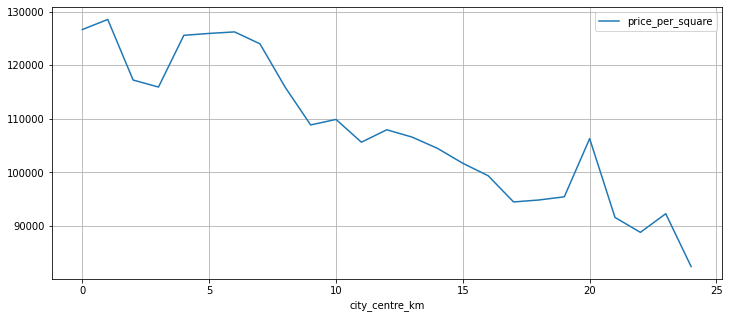

In [59]:
spb_centre = df_clean.loc[df_clean["locality_name"] == "Санкт-Петербург"].copy()
spb_centre["city_centre_km"] = (
    spb_centre["cityCenters_nearest"] / 1000).fillna(999999).astype(int)
spb_centre = spb_centre.loc[spb_centre["city_centre_km"] < 25]

spb_centre.pivot_table(
    index="city_centre_km",
    values="price_per_square").plot(figsize=(12,5), grid=True)
plt.show()

Price drops in St. Petersburg occur when moving away from the center by more than 10 km, not considering the price drop around 3 km, which could be considered the city center.

In [60]:
spb_centre_km_price = spb_centre.query(
    "locality_name == 'Санкт-Петербург' & city_centre_km <= 10").pivot_table(
    index = "city_centre_km",
    values = "price_per_square",
    aggfunc = "mean")
spb_centre_km_price

,price_per_square
city_centre_km,
0,126664.824561
1,128547.273196
2,117242.607843
3,115934.004348
4,125585.597610
5,125938.449675
6,126223.287206
7,124001.166667
8,115863.675851


The cost per square meter varies depending on the distance from "0 km" and probably on the district where the sales object is located.

### Analysis of the apartment segment in the city center

There will be a separate data frame for apartments within a 10 km radius:

In [61]:
spb_centre_df = spb_centre.query(
    "locality_name == 'Санкт-Петербург' & city_centre_km <= 10")

#### Overview of parameters

Diagrams for each of the parameters:

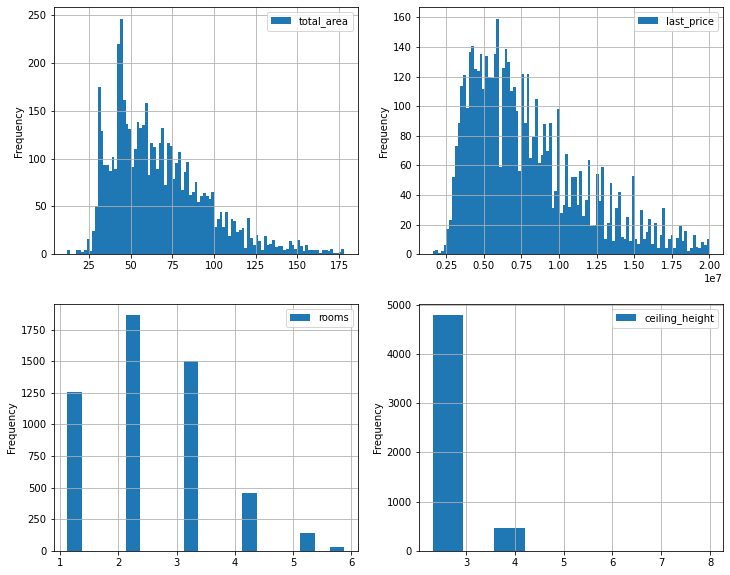

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
spb_centre_df.plot(y="total_area", kind="hist",
                   bins=100, ax=axs[0, 0], grid=True)
spb_centre_df.plot(y="last_price", kind="hist",
                   bins=100, ax=axs[0, 1], grid=True)
spb_centre_df.plot(y="rooms", kind="hist",
                   bins=10, ax=axs[1, 0], grid=True, rwidth=0.5)
spb_centre_df.plot(y="ceiling_height", kind="hist",
                   bins=5, ax=axs[1, 1], grid=True, rwidth=0.5)
plt.show()

A typical real estate sales ad in the center of St. Petersburg is for a property with an area of approximately 30 to 90 square meters, priced from 3 to 9 million rubles, with two or three rooms, occasionally one, and a standard ceiling height ranging from 2.7 to 3.0 meters.

#### Factors affecting the cost

Here are the grid of subplots for each factor:

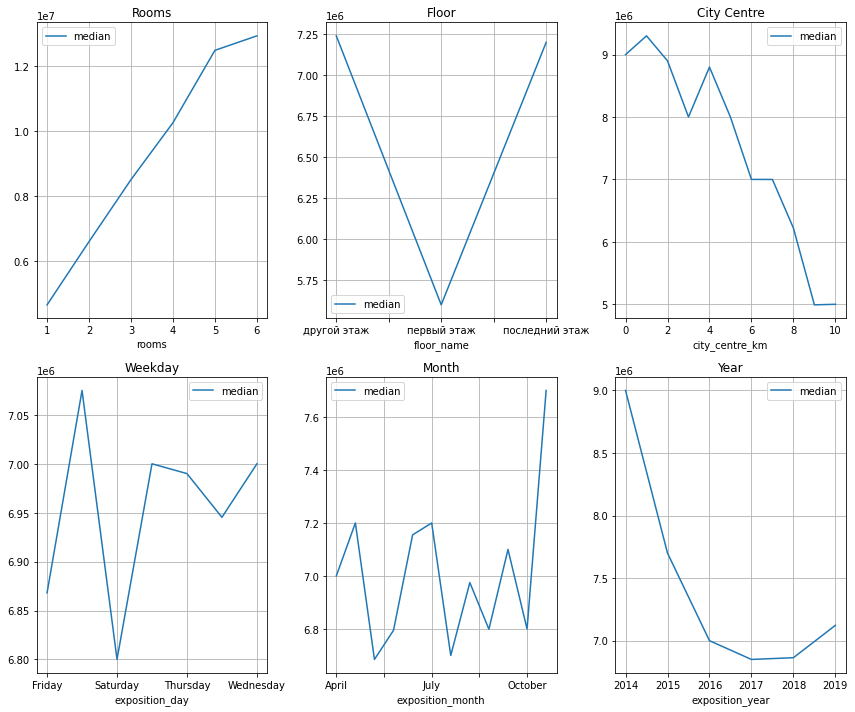

In [63]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))

# Plot 1
spb_centre_rooms = spb_centre_df.pivot_table(index='rooms', values='last_price', aggfunc='median')
spb_centre_rooms.columns = ['median']
spb_centre_rooms.plot(y='median', grid=True, ax=axes[0, 0])
axes[0, 0].set_title('Rooms')

# Plot 2
spb_centre_floor = spb_centre_df.pivot_table(index='floor_name', values='last_price', aggfunc='median')
spb_centre_floor.columns = ['median']
spb_centre_floor.plot(y='median', grid=True, ax=axes[0, 1])
axes[0, 1].set_title('Floor')

# Plot 3
spb_centre_city_centre = spb_centre_df.pivot_table(index='city_centre_km', values='last_price', aggfunc='median')
spb_centre_city_centre.columns = ['median']
spb_centre_city_centre.plot(y='median', grid=True, ax=axes[0, 2])
axes[0, 2].set_title('City Centre')

# Plot 4
spb_centre_weekday = spb_centre_df.pivot_table(index='exposition_day', values='last_price', aggfunc='median')
spb_centre_weekday.columns = ['median']
spb_centre_weekday.plot(y='median', grid=True, ax=axes[1, 0])
axes[1, 0].set_title('Weekday')

# Plot 5
spb_centre_month = spb_centre_df.pivot_table(index='exposition_month', values='last_price', aggfunc='median')
spb_centre_month.columns = ['median']
spb_centre_month.plot(y='median', grid=True, ax=axes[1, 1])
axes[1, 1].set_title('Month')

# Plot 6
spb_centre_year = spb_centre_df.pivot_table(index='exposition_year', values='last_price', aggfunc='median')
spb_centre_year.columns = ['median']
spb_centre_year.plot(y='median', grid=True, ax=axes[1, 2])
axes[1, 2].set_title('Year')

plt.tight_layout()
plt.show()

Correlation values:

In [64]:
r_corr = spb_centre_df["rooms"].corr(spb_centre_df["last_price"])
c_corr = spb_centre_df["city_centre_km"].corr(spb_centre_df["last_price"])

print(f"Correlation between number of rooms and last price: {r_corr:.2f}")
print(f"Correlation between city centre distance and last price: {c_corr:.2f}")

Correlation between number of rooms and last price: 0.52
Correlation between city centre distance and last price: -0.36


Sales in the city center are not significantly different from overall sales in the database, except for a slight dip in prices during the period of 2015-2016.

## Conclusion

The study found that:

1. There is a direct correlation between the cost of real estate and:
    - Number of rooms
    - Floor level (ads for apartments on the first floor are always cheaper)
    - A notable fact was the increase in prices on Tuesdays and the price decrease in the middle of the year (summer)
2. Prices decreased each year starting from 2014 (possibly due to the decline of the ruble), and by 2019, the market began showing a trend of growth.
3. The average area of apartments advertised was 50 square meters, priced from 2.5 to 7 million rubles.
4. The most expensive apartments were found in St. Petersburg, where the average cost per square meter in the city center is 126,664 rubles (112,109 rubles on average in the city). The city also had the highest number of ads for sales. Murino came in second with the highest number of ads after St. Petersburg. The cheapest cost per square meter was in Vyborg, at 58,075 rubles. Pushkin was third in terms of cost per square meter, with a price of 101,867 rubles.